In [65]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution

import sys
sys.path.append('../scripts')

import models
import data
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
param_space = {
    "min_child_weight" : FloatDistribution(0.01, 10, log = True),
    "n_estimators" : IntDistribution(20, 100),
    "eta" : FloatDistribution(0.01, 0.5),
    "max_leaves" : IntDistribution(2, 128),
    "max_depth" : IntDistribution(3, 10),
    "l2_weight" : FloatDistribution(0, 100),
    "fair_weight" : FloatDistribution(0, 0) 
}
param_space_fair = param_space.copy()
param_space_fair["fair_weight"] = FloatDistribution(0.01, 100)

In [95]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

def tune_hyperparam(X, Y, param_space):
    model = models.XtremeFair(alpha = 0.5)
    search = OptunaSearchCV(
        model,
        param_space,
        n_trials=20,
        cv=ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42),
        n_jobs=1,
        random_state=42,
        verbose=0,
    )
    search.fit(X, Y)
    model = models.XtremeFair(**search.best_params_)
    model.fit(X, Y)
    return model

def eval_model(model, X, Y):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    eop = utils.equal_opportunity_score(Y, y_pred, X.iloc[:, 0].values)
    spd = utils.statistical_parity_score(Y, y_pred, X.iloc[:, 0].values)
    el = utils.equalized_loss_score(Y, y_prob, X.iloc[:, 0].values)
    roc = roc_auc_score(Y, y_pred)
    return eop, spd, el, roc

for dataset in ["german", "taiwan"]:
    X, Y = data.load_dataset(dataset)
    for train_index, test_index in kf.split(X):
        X_train, Y_train = X.iloc[train_index], Y.iloc[train_index]
        X_test, Y_test = X.iloc[test_index], Y.iloc[test_index]
        
        model = tune_hyperparam(X_train, Y_train, param_space)
        eop, spd, el, roc = eval_model(model, X_train, Y_train)
        results.append(
            ["no_fair",
            dataset,
            eop,
            spd,
            el,
            roc,
            ]
        )

        model = tune_hyperparam(X_train, Y_train, param_space_fair)
        eop, spd, el, roc = eval_model(model, X_train, Y_train)
        
        results.append([
            "fair",
            dataset,
            eop,
            spd,
            el,
            roc
        ])
results = pd.DataFrame(results, columns=["fairness", "dataset", "eop", "spd", "el", "roc"])

/tmp/ipykernel_380/286430056.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(
[I 2023-12-07 22:58:32,781] A new study created in memory with name: no-name-c1d7cc44-8c76-4c21-9d59-82ccdd62204d
[I 2023-12-07 22:58:34,793] Trial 0 finished with value: 0.8135043501853942 and parameters: {'min_child_weight': 0.2312614033209604, 'n_estimators': 87, 'eta': 0.04383515702806606, 'max_leaves': 42, 'max_depth': 6, 'l2_weight': 29.826163136513074, 'fair_weight': 0.0}. Best is trial 0 with value: 0.8135043501853942.
[I 2023-12-07 22:58:35,872] Trial 1 finished with value: 0.807852303981781 and parameters: {'min_child_weight': 0.04337892866429277, 'n_estimators': 33, 'eta': 0.09634844023651915, 'max_leaves': 42, 'max_depth': 5, 'l2_weight': 99.92508603400948, 'fair_weight': 0.0}. Best is trial 0 with value: 0.8135043501853942.
[I 2023-12-07 22:58:39,024] Trial 2 finished with value: 0.80118052363395

In [99]:
results.groupby(["dataset", "fairness"]).mean().abs()

eop       spd        el       roc
dataset fairness                                        
german  fair      0.004677  0.062153  0.002626  0.774420
        no_fair   0.004250  0.019245  0.030001  0.735403
taiwan  fair      0.007398  0.012527  0.010209  0.622048
        no_fair   0.018083  0.024595  0.028246  0.681001

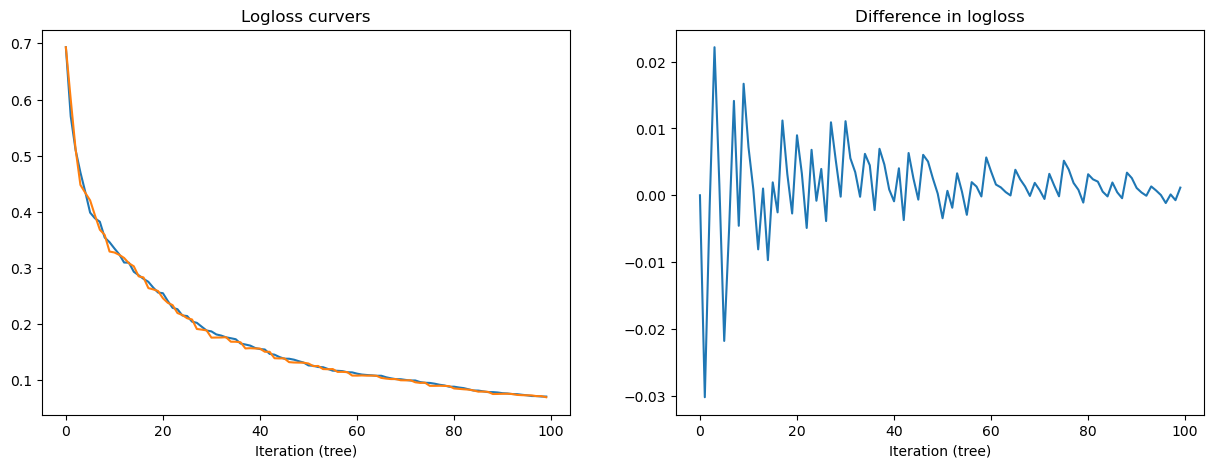

In [97]:
X, Y = data.load_dataset("german")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()

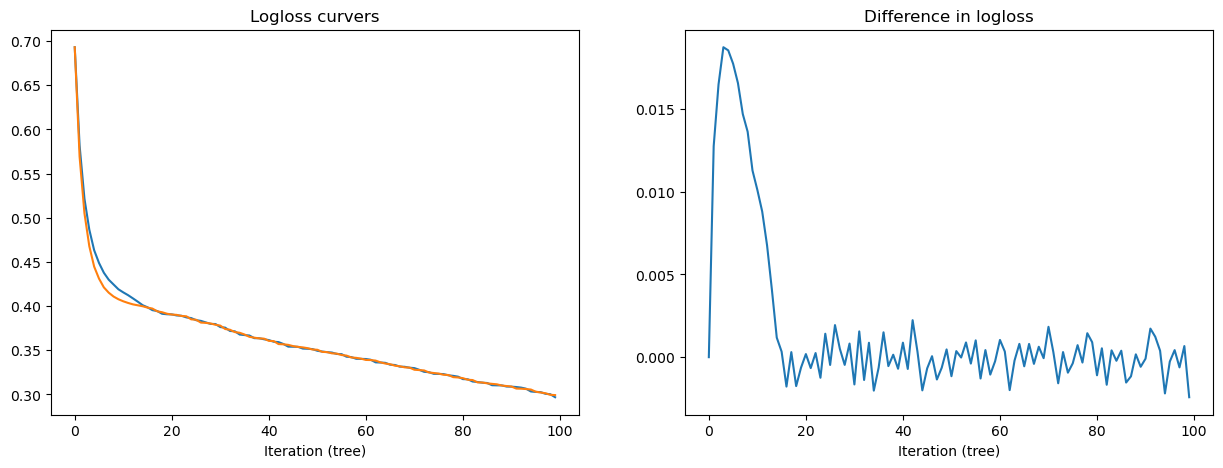

In [98]:
X, Y = data.load_dataset("taiwan")
model = models.XtremeFair(alpha = 0.5, n_estimators = 100)
model.fit(X, Y)
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(model.group_losses[:, 0]) 
plt.plot(model.group_losses[:, 1])
plt.title("Logloss curvers")
plt.xlabel("Iteration (tree)")
plt.subplot(1, 2, 2)
plt.plot(model.group_losses[:, 0] - model.group_losses[:, 1])
plt.title("Difference in logloss")
plt.xlabel("Iteration (tree)")
plt.show()